# **Emotions in Motion: Building a Mood Prediction Engine with FitLife**

##  **Project Aim**

 #### **This project is a part of my capstone for the `PG Certification Program in Applied Data Science and AI, E&ICT` from `IIT ROORKEE` in collaboration with `CloudxLab`.**

 #### **My goal here was to build a machine learning pipeline that can predict a person’s mood (`Bad`, `Neutral`, `Good`) based on their daily activities. I’ve used behavioral data like `activity type`, `duration`, `time of day`, and `emotional ratings` to train different models and evaluate how well they can understand emotional patterns.**


---

##  **About the Dataset**

#### **`FitLife: Emotions in Motion` is a synthetic but thoughtfully designed dataset that simulates how human emotions evolve throughout the day based on lifestyle activities. With `100,000+ records`, it offers a rare opportunity to explore `behavioral psychology` through the lens of `data science`.**

##  **Key Highlights:**
- #### **`Demographics`: Age, Gender**  
- #### **`Emotions`: Mood Before & After, Primary and Secondary Emotions**  
- #### **`Temporal Tags`: Date & Time of Day**  
- #### **`Activity Metrics`: Category, Sub-Category, Duration, Intensity**  
- #### **`Physical Factors`: Stress Level & Energy Level**  

##  **Why This Dataset Is Valuable:**
- #### **Understand how daily habits (exercise, social interaction, screen time, etc.) shape mood**
- #### **Detect emotional shifts based on behavioral patterns**
- #### **Apply ML for mental wellness forecasting**
- #### **Ideal for EDA, visual storytelling, classification models & time series insights**

## **Step 1: Import Required Libraries**
- #### **Load all the libraries used for data, visualization, modeling, and deep learning.**

In [1]:
import os
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

2025-07-24 16:21:06.722226: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 16:21:06.876327: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 16:21:07.008574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753354267.174399    8426 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753354267.216184    8426 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753354267.470814    8426 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## **Step 2: Load the Dataset**

- #### **This data allowed me to work on a real-world like problem that connects data science with human emotions and psychology.**


In [2]:
df = pd.read_csv('fitlife_dataset.csv')

## **Step 3: Initial Data Exploration**
- #### **View the first few rows and structure of your dataset.**

In [3]:
df.head()

,Date,Age,Gender,Employment Status,Time of Day,Activity Category,Sub-Category,Activity,Duration (minutes),Intensity,Primary Emotion,Secondary Emotion,Mood Before (1-10),Mood After (1-10),Energy Level (1-10),Stress Level (1-10)
0,2024-06-15,34,Male,Retired,Afternoon,Physical - Exercise,Mind-Body,Stretching,79,High,Energized,Challenged,3,3,6,9
1,2024-02-24,30,Prefer not to say,Retired,Night,Physical - Sports,Extreme Sports,Bungee Jumping,72,High,Accomplished,Accomplished,6,7,4,9
2,2024-06-05,75,Female,Employed,Night,Relaxation,Entertainment,Music Listening,117,High,Energized,Recharged,7,8,7,6
3,2024-06-05,28,Prefer not to say,Retired,Night,Relaxation,Leisure,Baking,78,High,Accomplished,Serene,7,8,8,9
4,2024-01-05,75,Female,Student,Afternoon,Physical - Sports,Team Sports,Basketball,55,Medium,Flexible,Challenged,7,8,6,2


In [4]:
print(f"Total Rows: {df.shape[0]}\n Total Columns: {df.shape[1]}")

Total Rows: 100000
 Total Columns: 16


## **Step 4: Check Data Types and Summary**
- #### **Understand the column data types, distributions, and missing values.**

In [5]:
# Check for null values across all columns
print(df.isnull().sum())

# Check total number of missing cells
print("\nTotal missing values:", df.isnull().sum().sum())

Date                   0
Age                    0
Gender                 0
Employment Status      0
Time of Day            0
Activity Category      0
Sub-Category           0
Activity               0
Duration (minutes)     0
Intensity              0
Primary Emotion        0
Secondary Emotion      0
Mood Before (1-10)     0
Mood After (1-10)      0
Energy Level (1-10)    0
Stress Level (1-10)    0
dtype: int64

Total missing values: 0


In [6]:
df.dtypes

Date                   object
Age                     int64
Gender                 object
Employment Status      object
Time of Day            object
Activity Category      object
Sub-Category           object
Activity               object
Duration (minutes)      int64
Intensity              object
Primary Emotion        object
Secondary Emotion      object
Mood Before (1-10)      int64
Mood After (1-10)       int64
Energy Level (1-10)     int64
Stress Level (1-10)     int64
dtype: object

## **Step 5: Mood Categorization**	
- #### **Since the mood was given as a number between 1 and 10, I decided to convert it into three categories to make the problem a multi-class classification:**

- **Bad (1 to 3)**
- **Neutral (4 to 6)**
- **Good (7 to 10)**

- #### **This made it easier to train the models and also more meaningful when interpreting the results.**


In [7]:
def categorize_mood(score):
    if score <= 3:
        return 'Bad'
    elif 3 < score <= 6:
        return 'Neutral'
    else:
        return 'Good'

## **Step 6: Check Mood Category Distribution**	
- #### **See how balanced or imbalanced the mood labels are.**

In [8]:
df['Mood Category'] = df['Mood After (1-10)'].apply(categorize_mood)
print(df['Mood Category'].value_counts())

Mood Category
Neutral    47649
Good       37780
Bad        14571
Name: count, dtype: int64


## **Step 7: Drop Irrelevant Columns and Define Features & Target**
- #### **Drop columns like Date, Mood After (used for label), and separate X and y.**

In [9]:
df = df.drop(columns=['Date', 'Mood After (1-10)'])

In [10]:
df.head()

,Age,Gender,Employment Status,Time of Day,Activity Category,Sub-Category,Activity,Duration (minutes),Intensity,Primary Emotion,Secondary Emotion,Mood Before (1-10),Energy Level (1-10),Stress Level (1-10),Mood Category
0,34,Male,Retired,Afternoon,Physical - Exercise,Mind-Body,Stretching,79,High,Energized,Challenged,3,6,9,Bad
1,30,Prefer not to say,Retired,Night,Physical - Sports,Extreme Sports,Bungee Jumping,72,High,Accomplished,Accomplished,6,4,9,Good
2,75,Female,Employed,Night,Relaxation,Entertainment,Music Listening,117,High,Energized,Recharged,7,7,6,Good
3,28,Prefer not to say,Retired,Night,Relaxation,Leisure,Baking,78,High,Accomplished,Serene,7,8,9,Good
4,75,Female,Student,Afternoon,Physical - Sports,Team Sports,Basketball,55,Medium,Flexible,Challenged,7,6,2,Good


In [11]:
print(f"Total Rows: {df.shape[0]}\n Total Columns: {df.shape[1]}")

Total Rows: 100000
 Total Columns: 15


## **Step 8: Separate Features and Target Variable**	
 #### **In this step, we separate the dataset into:**
- #### **X: all input features used for prediction.**
-  #### **y: Target variable set as "Mood Category"**

In [12]:
X = df.drop(columns=['Mood Category'])
y = df['Mood Category']

## **Step 9: Train-Test Split**
- #### **Split data into training and testing sets for modeling.**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [14]:
print('X Train Shape:', X_train.shape)
print('X Test Shape:', X_test.shape)

X Train Shape: (80000, 14)
X Test Shape: (20000, 14)


## **Step 10: Convert Categorical Features using One-Hot Encoding**
- #### **Convert object-type columns to numeric using dummy variables.**

In [15]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [16]:
print(f"Total Rows: {X_train.shape[0]}\n Total Columns: {X_train.shape[1]}")

Total Rows: 80000
 Total Columns: 317


## **Step 11: Handle Class Imbalance using SMOTE**
- #### **When I checked the class distribution, I found that the classes were imbalanced — most entries were labeled as “Neutral”. To solve this, I used SMOTE (Synthetic Minority Oversampling Technique) to balance the training data.**

In [17]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [18]:
print(f"Total Rows: {X_train_resampled.shape[0]}\n Total Columns: {X_train_resampled.shape[1]}")

Total Rows: 114357
 Total Columns: 317


- #### **Visualizing class distribution before SMOTE**

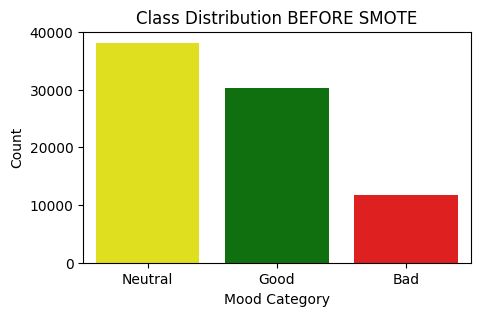

In [19]:
# Visualizing class distribution before SMOTE
plt.figure(figsize=(5,3))
sns.countplot(x=y_train, order=y_train.value_counts().index,  palette=['yellow', 'green', 'Red'])
plt.title("Class Distribution BEFORE SMOTE")
plt.xlabel("Mood Category")
plt.ylabel("Count")
plt.show()

- #### **After applying SMOTE, I visualized the class distribution again to confirm that the categories were now balanced.**

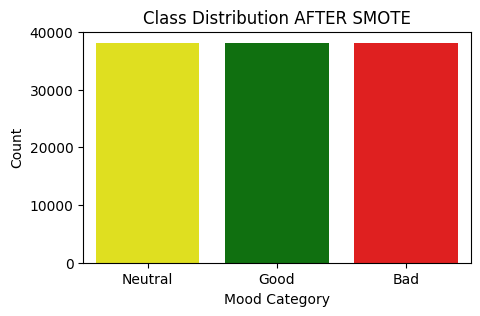

In [20]:
# Visualizing class distribution after SMOTE
plt.figure(figsize=(5,3))
sns.countplot(x=y_train_resampled, order=y_train_resampled.value_counts().index,  palette=['yellow', 'green', 'Red'])
plt.title("Class Distribution AFTER SMOTE")
plt.xlabel("Mood Category")
plt.ylabel("Count")
plt.show()

## **Step 12: Scale the Numerical Features using StandardScaler**
- #### **Normalize the features for better model performance.**

In [21]:
scaler = StandardScaler()
num_cols = ['Age', 'Duration (minutes)', 'Mood Before (1-10)', 'Energy Level (1-10)', 'Stress Level (1-10)']
X_train_resampled[num_cols] = scaler.fit_transform(X_train_resampled[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

- #### **Use label Encoder**

In [22]:
le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train_resampled))
y_test_enc = to_categorical(le.transform(y_test))

## **Step 13: Train Random Forest Model with GridSearchCV**
- #### **I started with a Random Forest model because it's easy to implement, performs well on structured data, and provides feature importance.I tuned the parameters using GridSearchCV and evaluated it using accuracy, F1-score, and a confusion matrix.**

In [23]:
# Define a smaller grid to avoid memory issues
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# GridSearch with 3-fold Cross-Validation
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=1, scoring='accuracy')

In [24]:
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model from GridSearch
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


## **Step 14: Evaluate Random Forest Performance**	
- #### **Print classification report and visualize results.**

In [25]:
# Predict & Evaluate on Test Set
y_pred_rf = best_rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Best Parameters:", grid_search.best_params_)
print("Accuracy: ", rf_acc)

Random Forest Classification Report:
               precision    recall  f1-score   support

         Bad       0.58      0.40      0.47      2914
        Good       0.79      0.83      0.81      7556
     Neutral       0.70      0.74      0.72      9530

    accuracy                           0.72     20000
   macro avg       0.69      0.66      0.67     20000
weighted avg       0.72      0.72      0.72     20000

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy:  0.724


- #### **Plot Confusion Matrix:**

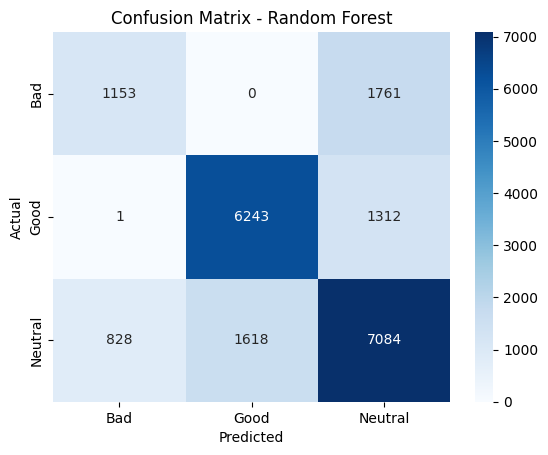

In [26]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## **Step 15: Feature Importance from Random Forest**	
- #### **Display top features affecting mood prediction.**

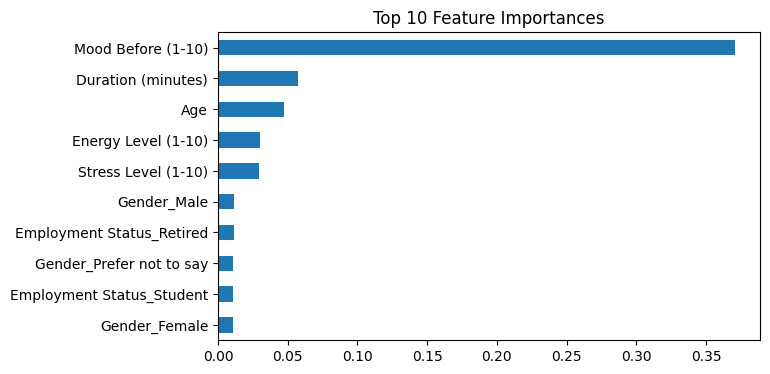

In [27]:
importances = best_rf.feature_importances_
features = X_test.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)[:10]

feat_imp.plot(kind='barh', figsize=(7,4), title="Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

## **Step16: XGBoost Model**

- #### **After Random Forest, I used XGBoost. It's known for giving high accuracy and usually performs better than traditional models on tabular data.**

- #### **It was slightly more accurate than Random Forest and gave better results for predicting the “Bad” mood category after balancing the classes.**

In [28]:
# Define and fit the XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
# Encode target labels into integers
le_xgb = LabelEncoder()
y_train_resampled_enc = le_xgb.fit_transform(y_train_resampled)
y_test_enc = le_xgb.transform(y_test)
xgb.fit(X_train_resampled, y_train_resampled_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## **Step 17: Evaluate XGBoost Performance**
- #### **View metrics like accuracy, precision, recall, f1-score.**

In [29]:
# Predict on test data
y_pred_xgb = xgb.predict(X_test)

# Evaluate
print(" XGBoost Classification Report:\n", classification_report(y_test_enc, y_pred_xgb))
xgb_acc = accuracy_score(y_test_enc, y_pred_xgb)

 XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.55      0.57      2914
           1       0.81      0.82      0.81      7556
           2       0.72      0.74      0.73      9530

    accuracy                           0.74     20000
   macro avg       0.71      0.70      0.71     20000
weighted avg       0.74      0.74      0.74     20000



- #### **Plot Confusion Matrix:**

<Figure size 600x500 with 0 Axes>

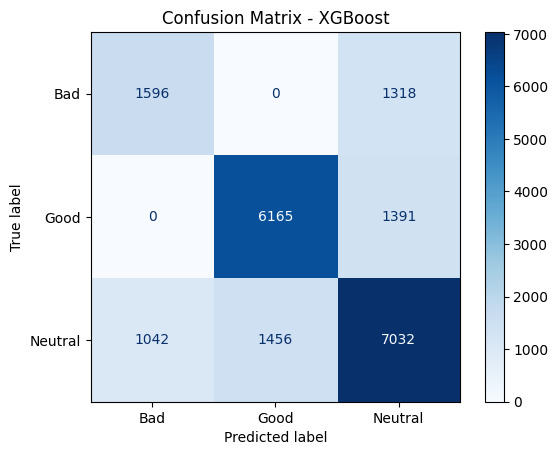

In [30]:
# Generate confusion matrix
cm_xgb = confusion_matrix(y_test_enc, y_pred_xgb)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=le_xgb.classes_)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.show()

## **Step 18:  Interpreting XGBoost using SHAP**

- #### **To understand what features influenced the predictions, I used SHAP (SHapley Additive Explanations).**

- #### **It helped me see that features like Activity Duration, Mood Before, Intensity, and Time of Day had the most impact on mood predictions. This part really helped me explain the model’s behavior instead of just showing numbers.**


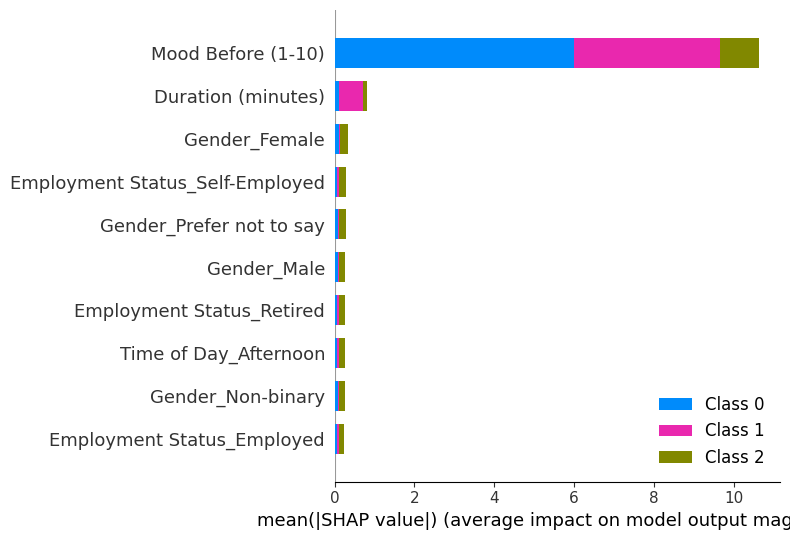

In [31]:
# Use same sample preprocessing as before
sample_data = X_test.sample(n=10000, random_state=42).astype('float64')

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(sample_data)
shap.summary_plot(shap_values, sample_data, plot_type="bar", max_display=10)

In [56]:
# Clear backend session to avoid overlapping graphs
K.clear_session()

## **Step 19: Use EarlyStopping and ReduceLROnPlateau Callbacks**
- #### **Prevent overfitting and auto-adjust learning rate.**

In [57]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

## **Step 20: Deep Learning Model (DNN)**

- #### **Finally, I trained a Deep Neural Network using TensorFlow. I used Batch Normalization, Dropout layers, EarlyStopping, and ReduceLROnPlateau to improve performance and avoid overfitting.**

- #### **The neural network performed slightly better than Random Forest and was equal to XGBoost in accuracy. I converted the labels into one-hot format for compatibility with softmax output.**


In [58]:
# Build DNN model
dnn = Sequential([
    Dense(256, input_shape=(X_train_resampled.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    
    Dense(3, activation='softmax')  # 3 output classes
])

In [59]:
dnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,531 (494.26 KB)

 Trainable params: 125,635 (490.76 KB)

 Non-trainable params: 896 (3.50 KB)

In [60]:
# Compile model
dnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## **Step 21: Train the Deep Neural Network**
- #### **Fit the DNN model on SMOTE data with proper callbacks.**

In [61]:
# Train model with early stopping and LR scheduler
history = dnn.fit(
    X_train_resampled, y_train_enc,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100


2025-07-24 17:50:30.745975: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 116002980 exceeds 10% of free system memory.


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7045 - loss: 0.6062 - val_accuracy: 0.9136 - val_loss: 0.2204 - learning_rate: 0.0010
Epoch 2/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.7601 - loss: 0.4671 - val_accuracy: 0.9365 - val_loss: 0.2485 - learning_rate: 0.0010
Epoch 3/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7649 - loss: 0.4509 - val_accuracy: 0.9459 - val_loss: 0.2004 - learning_rate: 0.0010
Epoch 4/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.7690 - loss: 0.4413 - val_accuracy: 0.9605 - val_loss: 0.1567 - learning_rate: 0.0010
Epoch 5/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.7720 - loss: 0.4332 - val_accuracy: 0.9639 - val_loss: 0.1528 - learning_rate: 0.0010
Epoch 6/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7732 - loss: 0.4337 - val_accuracy: 0.9491 - val_loss: 0.1864 - learning_rate: 0.0010
Epoch 7/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.7

In [62]:
# Predict
y_pred_dnn_prob = dnn.predict(X_test)
y_pred_dnn_enc = y_pred_dnn_prob.argmax(axis=1)
y_pred_dnn = le.inverse_transform(y_pred_dnn_enc)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## **Step 22: Evaluate DNN Performance**	
- #### **Print and analyze accuracy, recall, and f1-score.**

In [63]:
# Evaluate
from sklearn.metrics import classification_report, accuracy_score
print("DNN Classification Report:\n", classification_report(y_test, y_pred_dnn))
dnn_acc = accuracy_score(y_test, y_pred_dnn)

DNN Classification Report:
               precision    recall  f1-score   support

         Bad       0.60      0.61      0.60      2914
        Good       0.84      0.78      0.81      7556
     Neutral       0.72      0.75      0.74      9530

    accuracy                           0.74     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.75      0.74      0.74     20000



- #### **Plot Confusion Matrix:**

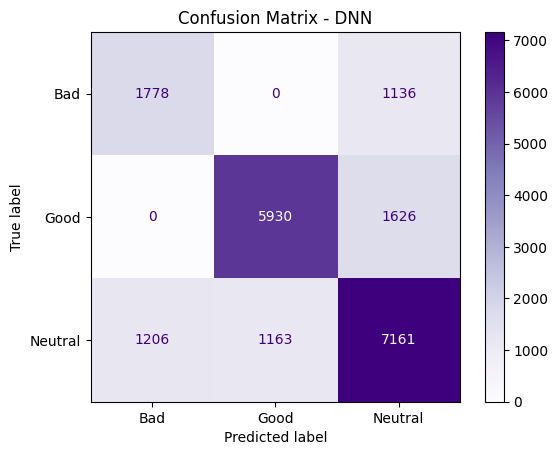

In [64]:
dnn_cm = confusion_matrix(le.transform(y_test), y_pred_dnn_enc)
disp = ConfusionMatrixDisplay(confusion_matrix=dnn_cm, display_labels=le.classes_)
disp.plot(cmap="Purples")
plt.title("Confusion Matrix - DNN")
plt.show()

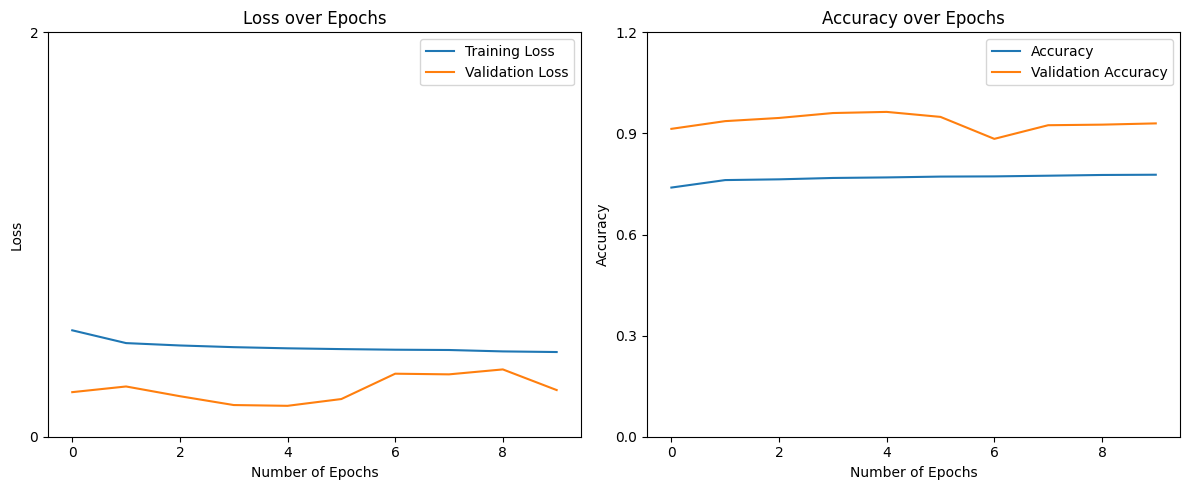

In [65]:
fig, axis = plt.subplots(1, 2, figsize=(12, 5))

axis[0].plot(history.history['loss'], label = 'Training Loss')
axis[0].plot(history.history['val_loss'], label = 'Validation Loss')

axis[1].plot(history.history['accuracy'], label = 'Accuracy')
axis[1].plot(history.history['val_accuracy'], label = 'Validation Accuracy')

axis[0].set_title("Loss over Epochs")
axis[0].set_xlabel('Number of Epochs')
axis[0].set_ylabel('Loss')

axis[1].set_title("Accuracy over Epochs")
axis[1].set_xlabel('Number of Epochs')
axis[1].set_ylabel('Accuracy')

axis[0].set_yticks(np.arange(0, max(max(history.history['loss']), max(history.history['val_loss'])) + 2, 2))
axis[1].set_yticks(np.arange(0, max(max(history.history['accuracy']), max(history.history['val_accuracy'])) + 0.3, 0.3))

axis[0].legend()
axis[1].legend()

plt.tight_layout()
plt.show()

## **Step 23:  Comparing All Models**

- #### **After training all three models, I compared their test accuracies:**

- #### **Random Forest: ~72%**
- #### **XGBoost: ~74%**
- #### **DNN: ~74%**

- #### **XGBoost and DNN performed better than Random Forest, especially in predicting the Bad and Good mood classes.**


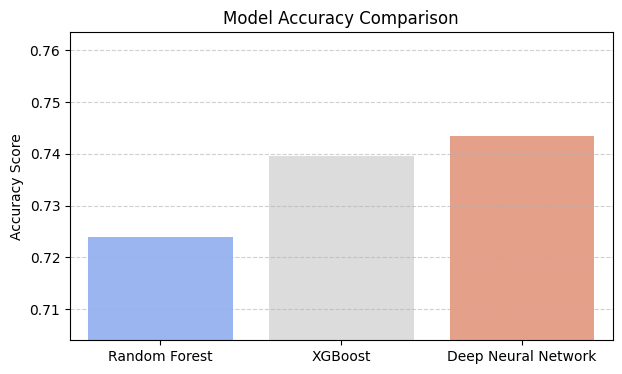

In [66]:
# Final comparison of all models
model_names = ['Random Forest', 'XGBoost', 'Deep Neural Network']
accuracy_scores = [rf_acc, xgb_acc, dnn_acc]

plt.figure(figsize=(7,4))
sns.barplot(x=model_names, y=accuracy_scores, palette='coolwarm')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy Score")
plt.ylim(min(accuracy_scores) - 0.02, max(accuracy_scores) + 0.02)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## **Final Summary and Takeaways**

#### **This project helped me understand how emotional patterns can be analyzed using machine learning.**

#### **Here’s what I achieved:**
- #### **Converted numerical mood scores into useful categories**
- #### **Balanced the data using SMOTE**
- #### **Applied and compared 3 powerful models: RF, XGBoost, and DNN**
- #### **Used SHAP to explain the model’s decision-making**

### **My Observations:**
- #### **XGBoost and DNN performed the best overall**
- #### **Intensity, Mood Before, and Duration were key features across all models**
- #### **Balancing the classes made a big difference, especially for the “Bad” mood predictions**

> #### **This was a great experience — from data cleaning to deploying deep learning models with interpretation. I’m confident that this project shows my readiness to solve real-world problems using data science.**


# **About Me**

#### **Name:** Prince Raj  
#### **Program:** Postgraduate Certificate in Data Science and AI
#### **Institute:** IIT Roorkee x CloudxLab  
#### **Submission:** August 2025 Capstone Project